# Assignment 5

**Submitted By: Jagmeet Singh**

**Problem Description:** It is a binary classification problem based on the graph data. The task is to predict the anticancer activity of a chemical compound using the chemical structure of the compound. The chemical compound can be positive or negative against lung cancer cell and thus labelled as either 0 or 1. 

**Data Description:** The data is in the form of graph which represents the chemical structure of the compound. Each sample of data contains information about the atoms and the connections between atoms of the molecule. So in this problem the features are the atoms and connections.

**Methods Used:**

1. The first step is to read the sdf file to get the information about the atoms and their connectivity in the compound. The atoms are described as nodes and connections are described as edges. The read_sdf method is used to read sdf file and the chemical composition of the compound.

2. The nodes(atoms) are given as characters (like \['O','N','Cl'....]). Thus it is treated as sequence of text data and best way to describe the text data sequence to tokenize the data and then adding the embeddig layer. 

3. Graph convolutional network is used in this assignment to calculate the probability of the output class. Different methods differ in implementing message passing methods as:

* **R-GCN Method**: (Graph convolution layers) Compute new graph states by neural message passing.

* **R-GAT Method**: (Relation graph attention network layer) Compute new graph states by neural message passing using attention.

* **R-GIN Method**: (Relation Graph Isomorphism Network message propogation layer) Compute new graph states by neural message passing using MLPs for state updates and message computation.

* **GGNN Method**: (Gated graph neural network layer) Compute new graph states by neural message passing and gated units on the nodes. This method works best for this problem as given in Aggregation Method 2 below.

In [ ]:
#Mounting google drive to import data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Read SDF format data (structured-data format)

In [ ]:
#importing libraries
import numpy as np   
from tqdm.notebook import tqdm

#method to read sdf file
#the chemical composition of a molecule is saved as SDF(structure data file) file
#sdf file store information about position of individual atom
#molecules are delimited by $$$$
#the atom block lines start with '    ' and have information about atoms(C,O,N,Cl..)
#bond block starts with ' ' and contains info about connection between atoms

def read_sdf(file):
    with open(file, 'r') as rf:   #opening the file in read mode
        content = rf.read()       #reading the contents of the file
    samples = content.split('$$$$') #splitting the read file by delimiter $$$$ thus splitting each molecule in an array
    
    #method to read each molecule configuration
    #s represents one molecule
    def parse_sample(s):
        lines = s.splitlines()    #splitting the text data to lines
        links = []                #empty array for links
        nodes = []                #empty array for nodes
        label = 0
        for l in lines:           #loop over each line
            if l.strip() == '1.0':   #
                label = 1
            if l.strip() == '-1.0':
                label = 0
            if l.startswith('    '):  #for Atom block  
                feature = l.split()   #splitting line
                node = feature[3]     #node feature (atom) as O,C etc.
                nodes.append(node)    #appending nodes
            elif l.startswith(' '):   #bond block tells about connections between atoms
                lnk = l.split()       #splitting line
                # edge: (from, to,) (1-based index)
                if int(lnk[0]) - 1 < len(nodes):   #
                    links.append((   #appending links
                        int(lnk[0])-1,   #first atom
                        int(lnk[1])-1, # zero-based index #second atom
                        # int(lnk[2]) ignore edge weight
                    ))
        return nodes, np.array(links), label #returning nodes, links and label
    
    return [parse_sample(s) for s in tqdm(samples) if len(s[0]) > 0]  #parse_sample for each molecule

In [ ]:
from sklearn.model_selection import train_test_split

#reading train.sdf file
training_set = read_sdf('drive/My Drive/CISC873/A5/train.sdf')

#splitting the train data
training_set, validation_set = train_test_split(training_set, test_size=0.15,)

In [ ]:
#reading test file
testing_set  = read_sdf('drive/My Drive/CISC873/A5/test_x.sdf')

# Visualizing/Inspecting a Sample

* Training set contains data for each sample(molecule). Each sample array contains three elements. First element has information about the atoms in text format, second element has information about the connections and third element tells about the label for each molecule.

In [ ]:
#importing libraries for displaying network of molecule
!pip install --quiet networkx
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import cm
colors = cm.rainbow(np.linspace(0, 1, 50))

In [ ]:
#method to visualize the compound graph
#atoms are given as nodes
#the connections are defined as edges


def visualize(sample):
    G=nx.Graph() #initiating an instance of Graph
    nodes = sample[0] #atoms as nodes
    edges = sample[1] #connections as edges
    
    labeldict={} #empty dictionary for labels for the nodes
    node_color=[] #empty array for each node color
    for i,n in enumerate(nodes): #for each node in the sample
        G.add_node(i)   #adding node to the graph each node as (0,1,2,3..)
        labeldict[i]=n  #dictionary building with [key,value] as [0:'C']
        #print(i)
        #print(n)
        node_color.append(colors[hash(n)%len(colors)]) #color coding

    # a list of nodes:
    for e in edges: #for each edge
        G.add_edge(e[0], e[1]) #adding egde to the graph from one connection to other connection

    #drawing the graph with labels for nodes as atoms and connections as edges    
    nx.draw(G, labels=labeldict, with_labels = True, node_color = node_color)
    plt.show()
    #returns graph
    return G

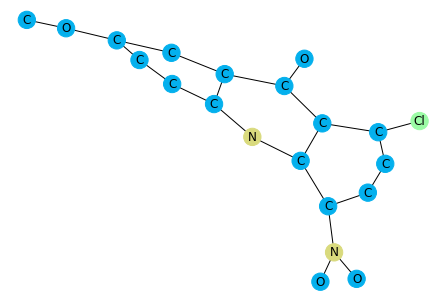

In [ ]:
#displaying one sample
plt.clf()
visualize(training_set[20])

# Preprocessing

In [ ]:
#checking the labels of the training dataset
labelss = []
for sam in training_set:
  labelss.append(sam[2])
np.unique(labelss,return_counts=True)  

(array([0, 1]), array([20253,  1017]))

In [ ]:
#checking the labels of the testing dataset
labelss = []
for sam in testing_set:
  labelss.append(sam[2])
np.unique(labelss,return_counts=True) 

(array([0]), array([12326]))

* Tokenizing the nodes(atoms)

In [ ]:
#Tokenizer importing 
from tensorflow.keras.preprocessing.text import Tokenizer

#vocabulary size
max_vocab = 500
max_len = 100 # maximum length of the tokenized vector


# build vocabulary from training set only for nodes characters
all_nodes = [s[0] for s in training_set]

#training tokenizer
tokenizer = Tokenizer(num_words=max_vocab)
tokenizer.fit_on_texts(all_nodes)

In [ ]:
#importing libraries
from tensorflow.keras.preprocessing.sequence import pad_sequences
import random
random.seed(0) #random seed


#method to prepare single batch set
#samples represents the batch of data
def prepare_single_batch(samples):
    sample_nodes = [s[0] for s in samples]                      #nodes characters array
    sample_nodes = tokenizer.texts_to_sequences(sample_nodes)   #tokenizing the sample nodes
    sample_nodes = pad_sequences(sample_nodes, padding='post')  #pad_sequences for each sample node with post padding
    max_nodes_len = np.shape(sample_nodes)[1]                   #maximum length of nodes 
    edges = [s[1]+i*max_nodes_len for i,s in enumerate(samples)] #defining edges
    edges = [e for e in edges if len(e) > 0]

    #each 
    node_to_graph = [[i]*max_nodes_len for i in range(len(samples))]  #array definition for segmented_ids
    
    all_nodes = np.reshape(sample_nodes, -1)  #reshaping as 1 vector
    all_edges = np.concatenate(edges)         #concatenating all the edges as size [total_edges ,2]

    node_to_graph = np.reshape(node_to_graph, -1)
    #returns a dictionary of features(data,edges,node2grah) and label
    return {
        'data': all_nodes,
        'edges': all_edges,
        'node2grah': node_to_graph,
    }, np.array([s[2] for s in samples]) 


#generating batch with given btch_size
def gen_batch(dataset, batch_size=16, repeat=False, shuffle=True):
    while True:                 #infinity loop
        dataset = list(dataset) #data in the array
        if shuffle:             # if shuffle is True
            random.shuffle(dataset) #randomly shuffling
        l = len(dataset)  #length of dataset
        for ndx in range(0, l, batch_size):  #loop for  creating batches from given dataset
            batch_samples = dataset[ndx:min(ndx + batch_size, l)] #creating batch samples with given batch_size
            yield prepare_single_batch(batch_samples)   #returning a generator with prepared batches
        if not repeat:  #breaking loop if repeat is false
            break

In [ ]:
# showing one batch:
for train_batch in gen_batch(training_set, batch_size=10):
    for k,v in train_batch[0].items():
        print(k)        
        print(v)
        print("Shape is "+str(np.shape(v)))
        pass
    print('label', train_batch[1])
    break

In [ ]:
!pip install --quiet tf2_gnn

# https://github.com/microsoft/tf2-gnn
# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py

#for deep Graph Neural Network
from tf2_gnn.layers.gnn import GNN, GNNInput

     |████████████████████████████████| 51kB 4.1MB/s 
     |████████████████████████████████| 71kB 5.5MB/s 
     |████████████████████████████████| 1.1MB 11.0MB/s 
     |████████████████████████████████| 194kB 21.1MB/s 
     |████████████████████████████████| 2.6MB 20.7MB/s 


## Aggregation Method 1

In [ ]:
#importing tensorflow and other libraries
import tensorflow as tf
from tensorflow.math import segment_mean #to calculate segmented mean
from tensorflow import keras
from tensorflow.keras import Input, Model #layers and model
from tensorflow.keras.layers import Embedding, Dense #layers
from tensorflow.keras.optimizers import Adam #optimizer


'''

To understand the dimensions:
Let's assume the batch contains 10 samples of data.
The nodes are tokenized using 44 dimension array that is each sample node is of shape [44]
Thus 10 samples are of shape [440] after applying get_batch method
node2graph is also of shape [440] like [0,0,0,0,0,...,1,1,1,1,....2,2,2,....] each number is repeated 44 times [0,0,0,0,... 44 times]
Lets assume edges are of size [257,2]

The GNN layer takes a GNNInput named tuple as input, which encapsulates initial node features, adjacency lists, and auxiliary information.

'''

data = keras.Input(batch_shape=(None,))  #Input layer for nodes (tokenized text data)            eg. [440]

# the first dim is different to the previous one. it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)     #Input layer for edge data         eg. [257,2]
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32) #Input layer for node2graph ids    eg. [440]

embeded = Embedding(tokenizer.num_words, 100)(data)  #embedding layer over data with each token embedded as  size vector eg. [440,50]


# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1  #calculating number of samples (or min(batch_size,no._of_samples))    eg. 10

#gnn_input layer with inputs as defined above
gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
#defining hyperparameters for GNN layer
params = GNN.get_default_hyperparameters()
params["hidden_dim"] = 40  #defining hidden dimension of the gnn layer

#gnn layer with defined hyperparameters
gnn_layer = GNN(params)  

#gnn output layer 
gnn_out = gnn_layer(gnn_input) #outpur shape: [data_dimension,hidden layers]   eg. [440,64]

print('gnn_out', gnn_out)           

# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean

#calculating segmented mean based on segment_ids
avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
    )                                    #shape: [batch_size,64]  eg. [10,64]

print('mean:', avg)

#final dense layer with sigmoid
pred = Dense(1, activation='sigmoid')(avg)   #output shape: [batch_size,1] eg. []
print('pred:', pred)

#building model 
#inputs are data,edges and node2graph
#input: dictionary
#output: prediction value from dense layer
model = Model(
    inputs={
        'data': data, 
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)

#printing summary of the model
model.summary()

gnn_out Tensor("gnn_8/StatefulPartitionedCall:0", shape=(None, 40), dtype=float32)
mean: Tensor("SegmentMean_5:0", shape=(None, 40), dtype=float32)
pred: Tensor("dense_4/Sigmoid:0", shape=(None, 1), dtype=float32)
Model: "functional_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_30 (InputLayer)           [(None,)]            0                                            
__________________________________________________________________________________________________
input_28 (InputLayer)           [(None,)]            0                                            
__________________________________________________________________________________________________
tf_op_layer_Max_8 (TensorFlowOp [()]                 0           input_30[0][0]                   
_______________________________________________________________________

In [ ]:
model.compile(
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

In [ ]:
import math

batch_size = 8

#math.ceil: returns the smallest integral value greater than the number
num_batchs = math.ceil(len(training_set) / batch_size) #no. of batches for training data

num_batchs_validation = math.ceil(len(validation_set) / batch_size) #no. of batches for validation data

model.fit(
    gen_batch(
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=50,
    validation_data=gen_batch(
        validation_set, batch_size=16, repeat=True
    ),
    validation_steps=num_batchs_validation,
)

Epoch 1/50


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:432: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


2659/2659 [==============================] - 28s 11ms/step - loss: 0.2153 - auc: 0.5667 - val_loss: 0.2554 - val_auc: 0.4687
Epoch 2/50
2659/2659 [==============================] - 28s 10ms/step - loss: 0.2074 - auc: 0.5820 - val_loss: 0.2046 - val_auc: 0.5563
Epoch 3/50
2659/2659 [==============================] - 28s 10ms/step - loss: 0.2093 - auc: 0.5452 - val_loss: 0.2248 - val_auc: 0.5091
Epoch 4/50
2659/2659 [==============================] - 28s 10ms/step - loss: 0.2063 - auc: 0.5550 - val_loss: 0.2346 - val_auc: 0.3853
Epoch 5/50
2659/2659 [==============================] - 28s 10ms/step - loss: 0.2057 - auc: 0.5424 - val_loss: 0.1907 - val_auc: 0.6483
Epoch 6/50
2659/2659 [==============================] - 28s 11ms/step - loss: 0.2026 - auc: 0.5672 - val_loss: 0.1946 - val_auc: 0.6213
Epoch 7/50
2659/2659 [==============================] - 28s 10ms/step - loss: 0.2065 - auc: 0.5291 - val_loss: 0.2038 - val_auc: 0.5127
Epoch 8/50
2659/2659 [==============================] - 28s

In [ ]:
y_pred = model.predict(
    gen_batch(testing_set, batch_size=16, shuffle=False)
)
y_pred = np.reshape(y_pred, -1)

In [ ]:
len(y_pred)

12326

In [ ]:
import pandas as pd 
submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('sub_3.csv')

## Aggregation Method 2

In [ ]:
#GGNN,RGCN,RGAT,RGIN,GNN-Edge-MLP,GNN-FiLM
#import tf2_gnn.layers.message_passing.gnn_edge_mlp
from  tf2_gnn.layers.message_passing import rgat,rgin,rgcn,gnn_film,ggnn,gnn_edge_mlp

In [ ]:
#importing tensorflow and other libraries
import tensorflow as tf
from tensorflow.math import segment_mean #to calculate segmented mean
from tensorflow import keras
from tensorflow.keras import Input, Model #layers and model
from tensorflow.keras.layers import Embedding, Dense #layers
from tensorflow.keras.optimizers import Adam #optimizer


'''

To understand the dimensions:
Let's assume the batch contains 10 samples of data.
The nodes are tokenized using 44 dimension array that is each sample node is of shape [44]
Thus 10 samples are of shape [440] after applying get_batch method
node2graph is also of shape [440] like [0,0,0,0,0,...,1,1,1,1,....2,2,2,....] each number is repeated 44 times [0,0,0,0,... 44 times]
Lets assume edges are of size [257,2]

The GNN layer takes a GNNInput named tuple as input, which encapsulates initial node features, adjacency lists, and auxiliary information.

'''

data = keras.Input(batch_shape=(None,))  #Input layer for nodes (tokenized text data)            eg. [440]

# the first dim is different to the previous one. it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)     #Input layer for edge data         eg. [257,2]
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32) #Input layer for node2graph ids    eg. [440]

embeded = Embedding(tokenizer.num_words, 75)(data)  #embedding layer over data with each token embedded as  size vector eg. [440,75]


# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1  #calculating number of samples (or min(batch_size,no._of_samples))    eg. 10

#gnn_input layer with inputs as defined above
gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
#defining hyperparameters for GNN layer
params = GNN.get_default_hyperparameters()
params["hidden_dim"] = 32 #defining hidden dimension of the gnn layer
params["message_calculation_class"] = 'GGNN'
#params["num_edge_MLP_hidden_layers"] = 16
#gnn layer with defined hyperparameters
gnn_layer = GNN(params)  

#gnn output layer 
gnn_out = gnn_layer(gnn_input) #outpur shape: [data_dimension,hidden layers]   eg. [440,32]

print('gnn_out', gnn_out)           

# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean

#calculating segmented mean based on segment_ids
avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
    )                                    #shape: [batch_size,64]  eg. [10,32]

print('mean:', avg)

#final dense layer with sigmoid
fc1 = Dense(8,activation='relu')(avg) #Output [None,8]
#fc2 = Dense(64,activation='relu')(fc1)
pred = Dense(1, activation='sigmoid')(fc1)   #output shape: [batch_size,1] 
print('pred:', pred)

#building model 
#inputs are data,edges and node2graph
#input: dictionary
#output: prediction value from dense layer
model = Model(
    inputs={
        'data': data, 
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)

#printing summary of the model
model.summary()

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='gnn/StatefulPartitionedCall:0', description="created by layer 'gnn'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='tf.math.segment_mean/SegmentMean:0', description="created by layer 'tf.math.segment_mean'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_1/Sigmoid:0', description="created by layer 'dense_1'")
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None,)]            0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None,)]            0                               

In [ ]:
model.compile(
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

In [ ]:
import math

batch_size = 64

#math.ceil: returns the smallest integral value greater than the number
num_batchs = math.ceil(len(training_set) / batch_size) #no. of batches for training data

num_batchs_validation = math.ceil(len(validation_set) / batch_size) #no. of batches for validation data

model.fit(
    gen_batch(
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=2,
    validation_data=gen_batch(
        validation_set, batch_size=16, repeat=True
    ),
    validation_steps=num_batchs_validation,
   # callbacks=[
    #    tf.keras.callbacks.EarlyStopping(monitor='auc', patience=5, restore_best_weights=True,mode='max')]
)

Epoch 1/2
333/333 [==============================] - 28s 86ms/step - loss: 0.1846 - auc: 0.6380 - val_loss: 0.1901 - val_auc: 0.7529
Epoch 2/2
333/333 [==============================] - 28s 85ms/step - loss: 0.1818 - auc: 0.6666 - val_loss: 0.2037 - val_auc: 0.6357


In [ ]:
y_pred = model.predict(
    gen_batch(testing_set, batch_size=16, shuffle=False)
)
y_pred = np.reshape(y_pred, -1)

In [ ]:
len(y_pred)

12326

In [ ]:
import pandas as pd 
submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('sub_47.csv')

## Aggregation Method 3

In [ ]:
from  tf2_gnn.layers.message_passing import RGAT,  MessagePassing, MessagePassingInput

In [ ]:
#importing tensorflow and other libraries
import tensorflow as tf
from tensorflow.math import segment_mean #to calculate segmented mean
from tensorflow import keras
from tensorflow.keras import Input, Model #layers and model
from tensorflow.keras.layers import Embedding, Dense #layers
from tensorflow.keras.optimizers import Adam #optimizer


'''

To understand the dimensions:
Let's assume the batch contains 10 samples of data.
The nodes are tokenized using 44 dimension array that is each sample node is of shape [44]
Thus 10 samples are of shape [440] after applying get_batch method
node2graph is also of shape [440] like [0,0,0,0,0,...,1,1,1,1,....2,2,2,....] each number is repeated 44 times [0,0,0,0,... 44 times]
Lets assume edges are of size [257,2]

The GNN layer takes a GNNInput named tuple as input, which encapsulates initial node features, adjacency lists, and auxiliary information.

'''

data = keras.Input(batch_shape=(None,))  #Input layer for nodes (tokenized text data)            eg. [440]

# the first dim is different to the previous one. it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)     #Input layer for edge data         eg. [257,2]
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32) #Input layer for node2graph ids    eg. [440]

embeded = Embedding(tokenizer.num_words, 100)(data)  #embedding layer over data with each token embedded as  size vector eg. [440,100]


# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1  #calculating number of samples (or min(batch_size,no._of_samples))    eg. 10

#gnn_input layer with inputs as defined above
gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
#defining hyperparameters for GNN layer
params = GNN.get_default_hyperparameters()
params["hidden_dim"] = 12 #defining hidden dimension of the gnn layer
params["message_calculation_class"] = 'rgat'
#params["num_layers"] = 4
params["num_heads"] = 3

#params['num_aggr_MLP_hidden_layers'] = 12
#gnn layer with defined hyperparameters
gnn_layer = GNN(params)  

#gnn output layer 
gnn_out = gnn_layer(gnn_input) #outpur shape: [data_dimension,hidden layers]   eg. [440,12]

print('gnn_out', gnn_out)           

# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean

#calculating segmented mean based on segment_ids
avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
    )                                    #shape: [batch_size,64]  eg. [10,12]

print('mean:', avg)

#final dense layer with sigmoid
pred = Dense(1, activation='sigmoid')(avg)   #output shape: [batch_size,1] 
print('pred:', pred)

#building model 
#inputs are data,edges and node2graph
#input: dictionary
#output: prediction value from dense layer
model = Model(
    inputs={
        'data': data, 
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)

#printing summary of the model
model.summary()

gnn_out Tensor("gnn_8/StatefulPartitionedCall:0", shape=(None, 12), dtype=float32)
mean: Tensor("SegmentMean_4:0", shape=(None, 12), dtype=float32)
pred: Tensor("dense_5/Sigmoid:0", shape=(None, 1), dtype=float32)
Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_39 (InputLayer)           [(None,)]            0                                            
__________________________________________________________________________________________________
input_37 (InputLayer)           [(None,)]            0                                            
__________________________________________________________________________________________________
tf_op_layer_Max_12 (TensorFlowO [()]                 0           input_39[0][0]                   
_______________________________________________________________________

In [ ]:
model.compile(
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

In [ ]:
import math

batch_size = 16

#math.ceil: returns the smallest integral value greater than the number
num_batchs = math.ceil(len(training_set) / batch_size) #no. of batches for training data

num_batchs_validation = math.ceil(len(validation_set) / batch_size) #no. of batches for validation data

model.fit(
    gen_batch(
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=30,
    validation_data=gen_batch(
        validation_set, batch_size=16, repeat=True
    ),
    validation_steps=num_batchs_validation,
)

Epoch 1/30


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:432: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


1330/1330 [==============================] - 20s 15ms/step - loss: 0.2352 - auc: 0.4877 - val_loss: 0.2311 - val_auc: 0.5506
Epoch 2/30
1330/1330 [==============================] - 20s 15ms/step - loss: 0.1971 - auc: 0.5894 - val_loss: 0.2046 - val_auc: 0.6024
Epoch 3/30
1330/1330 [==============================] - 20s 15ms/step - loss: 0.1930 - auc: 0.6156 - val_loss: 0.1955 - val_auc: 0.6414
Epoch 4/30
1330/1330 [==============================] - 20s 15ms/step - loss: 0.1889 - auc: 0.6449 - val_loss: 0.1975 - val_auc: 0.6452
Epoch 5/30
1330/1330 [==============================] - 20s 15ms/step - loss: 0.1856 - auc: 0.6730 - val_loss: 0.1864 - val_auc: 0.6921
Epoch 6/30
1330/1330 [==============================] - 20s 15ms/step - loss: 0.1850 - auc: 0.6715 - val_loss: 0.1947 - val_auc: 0.6509
Epoch 7/30
1330/1330 [==============================] - 20s 15ms/step - loss: 0.1818 - auc: 0.6896 - val_loss: 0.1988 - val_auc: 0.6480
Epoch 8/30
1330/1330 [==============================] - 20s

In [ ]:
y_pred = model.predict(
    gen_batch(testing_set, batch_size=16, shuffle=False)
)
y_pred = np.reshape(y_pred, -1)

In [ ]:
len(y_pred)

12326

In [ ]:
import pandas as pd 
submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('sub_3.csv')

# Questions

### Ques 1: Based on the provided template, describe the format of the input file (sdf file).

Ans: The input file is structure data file (SDF). It contains information about the chemical composition of a molecule.
SDF file store information about position of individual atom in the chemical compound and also tells about the connections. Different molecules are delimited by '\$\$\$\$' expression. 

Each sample/molecule starts with header which tells about the name/title of the compound. Other sections includes information about Atom count, version number, connections etc. Atom block tells about the elements of the compound. Bond block block tells about the bonding structure of the compound. These both blocks are used in this assignment to get information about the compound and saving them in form of edges and nodes. Each node is the atom given in the chemical molecule.

### Ques 2: What are the input tensors to the neural network model (their meaning, not just symbol)? What is each of their dims and their meaning (e.g. batch_size?)?

Ans: The input tensors in this network are:

1. **data**: The data contains the nodes of the chemical compound in the tokenized form. Nodes for each compound are extracted, then they are tokenized using the tokenizer and finally padding is done using pad_sequence method. The shape for each batch is **\[batch_size*max_len_nodes]**, where batch_size is the number of samples in the batch and max_len_nodes is the length of tokenized nodes after padding is done.

2. **edge**: edge is the input tensor which carries information about connections between atoms. The shape of edge is **\[sum_of_all_edges,2]**. The sum_of_all_edges represents the sum(no. of edges of each sample) of the batch_size. For example in a batch of 3 samples, the number of edges in sample 1: 21, sample 2: 20 and sample 3: 40. So the size of edge tensor would be \[81,2].

3. **node2graph**: It is the input tensor which is used for segmented mean and contains information about segmented ids. The shape for each batch is **\[batch_size*max_len_nodes]**, where batch_size is the number of samples in the batch and max_len_nodes is the length of tokenized nodes after padding is done. 


### Ques 3: For each dim of gnn_out, what does it represent? For each dim of avg, what does it represent?

Ans: 

**gnn_out**: The gnn_out is of shape \[batch_size_node_dimension,hidden layers], where batch_size_node_dimension is the dimension of the input data (node) vector (dimension of tokenized vector for the complete batch). It represents the aggregation output of the model for each hidden layer.

**avg**: Average takes the segmented mean of the gnn_out based on the segmented ids. For each sample in the batch_size, the output of gnn_out is \[tokenized_vector_dimension, hidden_layers]. Each sample has one segment id. Thus the segment_mean takes the mean of all the output data in the gnn_out output and represents one sample with one number for each hidden layer. The final output of the avg tensor is of shape \[batch_size, hidden_layer]. It is a way of collecting information for each sample and representing it in the form of mean data.

### Ques 4: What is the difference between segment_mean and tf.reduce_mean? For each dim of pred, what does it represent?

Ans: **segment_mean** takes the mean of the data which have same segmented ids. 



**reduce_mean:** computes the mean of elements across dimensions of a tensor given the arguments.

**pred:** The final output (pred) tells about the probability of a chemical compound to be active for the cancer cell or not. The shape of pred is \[batch_size,1]. Thus for each sample, the final output is a number which represents the probability associated with each chemical compound about its activity.

### Ques 5: What is the motivation / theory/idea to use multiple gcn layers comparing to just one? How many layers were used in the template?

Ans: 

The default template implements the default setting of the number of layers in the gcn network. The default layer are **4** as given in the documentaion. The default message passing method is rgcn (Graph convolution layers). Using multiple gcn helps in incorporating all the graph complexity properly and thus creates a better model.